# CIS545: Final Project - CORD-19 Dataset
## Justin Choi
## TA: Hoyt Gong

Hi there! For this project, I opted to use the COVID-19 research challenge dataset, which they named "CORD-19" (I promise, the title wasn't a typo haha). Dataset was created by the Allen Institute for AI, Chan Zuckerberg Initiative, Microsoft Research, NIH, and more, so if you wanna check it out, you can [download](https://www.semanticscholar.org/cord19/get-started "AI2 link to dataset") it or check out the [Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks?taskId=568 "kaggle page!") webpage for it!

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import json


# The Data 
Thanks to all the ~ useful ~ skills we've picked up over the course of this semester, we'll start with everyone's favorite tedious, time-consuming task - data cleaning! woo hoooooOOOOooOo who doesn't lüv missing values and weird formatting. 

Most of the work in this section was basically just finding good ways to extract the text from the json format to put into the dataframe, and then proceeded to clean it using basic `pandas` and the `langdetect` package in order to filter out any articles not in English in order to standardize the data and simplify visualization/processing/modeling later on! 

In [2]:
metadata_df = pd.read_csv('./CORD-19-research-challenge/metadata.csv')

# Import all the json files
cord_19_folder = './CORD-19-research-challenge/'
list_of_files = []; # only going to take those from pdf_json! not pmc_json
for root, dirs, files in os.walk(cord_19_folder):
    for name in files:
        if (name.endswith('.json')):
            full_path = os.path.join(root, name)
            list_of_files.append(full_path)
sorted(list_of_files)
print('done')

# ALTERNATE

# all_json = glob.glob(f'{cord_19_folder}/**/*.json', recursive=True)
# len(all_json)


done


In [3]:
class JsonReader:
    def __init__(self, file_path):
        with open(file_path) as file: 
            content = json.load(file)
            # start to insert body text 
            self.paper_id = content['paper_id']
            self.body_text = [] 
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.body_text[:500]}...'

random_json = list_of_files[47404]
sample_article = JsonReader(random_json)
print(sample_article)

PMC1403753: Migration, transmigration, [1] return migration, and remigration constitute defining elements of the current and future world order. More than 700 million people (including visitors on business or personal/family trips) traverse nation-state borders annually [2,3] and one million per week move between the global South and the global North [4]. The enormity of contemporary transnational mobility is illustrated by the case of Australia. In the past half century, Australia's "resident population ha...


In [4]:
input = {'paper_id': [], 'doi':[],  'title': [], 'abstract': [], 'body_text': [], 'authors': [], 'journal': []}

for i, entry in enumerate(list_of_files):
    if i % (len(list_of_files) // 25) ==    0:
        print(f'Processing {i} of {len(list_of_files)}')
    try: 
        article = JsonReader(entry)
    except Exception as e: 
        continue #means that we don't have a valid file format  
    
    metadata = metadata_df.loc[metadata_df['sha'] == article.paper_id]
    if len(metadata) == 0:
        continue # no such metadata for paper in our csv, skip

    input['body_text'].append(article.body_text)
    input['paper_id'].append(article.paper_id)

    # add in metadata 
    title = metadata['title'].values[0] 
    doi = metadata['doi'].values[0] 
    abstract = metadata['abstract'].values[0] 
    authors = metadata['authors'].values[0] 
    journal = metadata['journal'].values[0] 

    input['title'].append(title)
    input['doi'].append(doi)
    input['abstract'].append(abstract)
    input['authors'].append(authors)
    input['journal'].append(journal)



Processing 0 of 59311
Processing 2372 of 59311
Processing 4744 of 59311
Processing 7116 of 59311
Processing 9488 of 59311
Processing 11860 of 59311
Processing 14232 of 59311
Processing 16604 of 59311
Processing 18976 of 59311
Processing 21348 of 59311
Processing 23720 of 59311
Processing 26092 of 59311
Processing 28464 of 59311
Processing 30836 of 59311
Processing 33208 of 59311
Processing 35580 of 59311
Processing 37952 of 59311
Processing 40324 of 59311
Processing 42696 of 59311
Processing 45068 of 59311
Processing 47440 of 59311
Processing 49812 of 59311
Processing 52184 of 59311
Processing 54556 of 59311
Processing 56928 of 59311
Processing 59300 of 59311


In [5]:
covid_df = pd.DataFrame(input, columns=['paper_id', 'doi', 'title', 'abstract', 'body_text', 'authors', 'journal'])
print('finished creating dataframe from input dictionary')
rows, cols = covid_df.shape
print(f'number of rows: {rows}')
covid_df.info()

finished creating dataframe from input dictionary
number of rows: 36009
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36009 entries, 0 to 36008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   36009 non-null  object
 1   doi        35672 non-null  object
 2   title      35973 non-null  object
 3   abstract   31675 non-null  object
 4   body_text  36009 non-null  object
 5   authors    35413 non-null  object
 6   journal    34277 non-null  object
dtypes: object(7)
memory usage: 1.9+ MB


In [6]:
covid_df.dropna(inplace=True)
print('finished dropping articles with null abstracts/body text/titles')
rows, cols = covid_df.shape
print(f'number of rows: {rows}')

finished dropping articles with null abstracts/body text/titles
number of rows: 29600


In [7]:
covid_df['body_word_count'] = covid_df['body_text'].apply(lambda x : len(x.strip().split()))
covid_df['body_unique_count'] = covid_df['body_text'].apply(lambda x : len(set(x.strip().split())))


In [8]:
# visualiation check to see if data is finished being cleaned 
covid_df.head()


,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count
0,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,10.1080/14787210.2017.1271712,Update on therapeutic options for Middle East ...,Introduction: The Middle East Respiratory Synd...,The Middle East respiratory syndrome coronavir...,"Al-Tawfiq, Jaffar A.; Memish, Ziad A.",Expert Rev Anti Infect Ther,174,2748,996
1,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,10.1093/cid/ciaa256,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...","Bryson-Cahn, Chloe; Duchin, Jeffrey; Makarewic...",Clin Infect Dis,50,944,486
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,10.1016/b978-0-12-800049-6.00293-6,Evolutionary Medicine IV. Evolution and Emerge...,Abstract This article discusses how evolutiona...,The evolutionary history of humans is characte...,"Scarpino, S.V.",Encyclopedia of Evolutionary Biology,72,2884,1091
3,6599ebbef3d868afac9daa4f80fa075675cf03bc,10.1016/j.enpol.2008.08.029,International aviation emissions to 2025: Can ...,Abstract International aviation is growing rap...,"Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew; Wallace, Lailey",Energy Policy,137,5838,1587
5,44290ff75bad8ffaf5d3028420739ce7b08dc2a9,10.1093/jac/dkp502,Inhibition of enterovirus 71 replication and t...,OBJECTIVES: Enterovirus 71 (EV71) causes serio...,Enteroviruses are members of the family Picorn...,"Hung, Hui-Chen; Chen, Tzu-Chun; Fang, Ming-Yu;...",J Antimicrob Chemother,260,3121,1064


In [9]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29600 entries, 0 to 36008
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             29600 non-null  object
 1   doi                  29600 non-null  object
 2   title                29600 non-null  object
 3   abstract             29600 non-null  object
 4   body_text            29600 non-null  object
 5   authors              29600 non-null  object
 6   journal              29600 non-null  object
 7   abstract_word_count  29600 non-null  int64 
 8   body_word_count      29600 non-null  int64 
 9   body_unique_count    29600 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.5+ MB


In [10]:
#check to see if there are duplicates
covid_df['abstract'].describe()

count       29600
unique      29543
top       Unknown
freq           21
Name: abstract, dtype: object

In [11]:
covid_df.drop_duplicates(subset=['abstract', 'body_text'], inplace=True)

In [14]:
covid_df.describe()

,abstract_word_count,body_word_count,body_unique_count
count,29597.000000,29597.000000,29597.000000
mean,194.711356,4560.325878,1425.199007
std,151.302225,3528.817632,748.579044
min,1.000000,2.000000,2.000000
25%,140.000000,2705.000000,989.000000
50%,191.000000,3847.000000,1288.000000
75%,243.000000,5533.000000,1695.000000
max,18000.000000,171948.000000,25156.000000


In [15]:
from langdetect import detect
from tqdm import tqdm

languages = [] # make list that you can port directly into covid_df as column

for i in tqdm(range(len(covid_df))):
    row_text = covid_df.iloc[i]['body_text'].split(" ") 
    lang = 'en' # set default lang to be english 

    # try to just use the intro 25 words to detect language
    try:
        if (len(row_text)) > 125: 
            lang = detect(" ".join(row_text[:125]))
        elif(len(row_text)) > 0:
            lang = detect(" ".join(row_text))
    except Exception as e: # if body doesn't work, let's try abstract
        try: 
            lang = detect(covid_df.iloc(i)['abstract'].split())
        except Exception as e:
            lang = 'dunno'
            continue
    finally:
        languages.append(lang)
        

100%|██████████| 29597/29597 [02:46<00:00, 178.13it/s]


In [16]:
lang_array = np.asarray(languages)
covid_df['language'] = lang_array
lang_dict = {}
for language in lang_array:
    if language in lang_dict:
        lang_dict[language] += 1
    else: 
        lang_dict[language] = 1
lang_dict

{'en': 29045,
 'fr': 246,
 'nl': 36,
 'es': 172,
 'it': 14,
 'de': 67,
 'pt': 12,
 'pl': 2,
 'cy': 1,
 'dunno': 1,
 'zh-cn': 1}

In [17]:
# test to see if languages were detected correctly
covid_df[covid_df['language'] == 'nl'].head(10)

,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count,language
56,7d1d1ee1fcc8f713f374f3d693861913a2730ac4,10.1007/978-90-313-6316-2_5,5 Zorgvuldig en verantwoord werken,Verzorgenden in verpleeg- en verzorgingshuizen...,Verzorgenden in verpleeg-en verzorgingshuizen ...,"Dito, J.C.; Stavast, T.; Zwart, D.E.",Basiszorg Boek 1,54,3808,1563,nl
390,74276b4789e8384757bce159941cef1e3920f312,10.1007/978-90-368-1813-1_2,Ademhaling,Dyspneu is een subjectieve sensatie van ineffi...,Klachten van het ademhalingsapparaat vormen va...,"Huybrechts, B. P. M.",Leerboek spoedeisende-hulp-verpleegkunde,148,14084,3991,nl
2020,8623787ac0fead8e9a536807c547de64db135ec9,10.1007/978-90-313-7944-6_2,2 Infecties van de bovenste luchtwegen,Luchtweginfecties in het algemeen en infecties...,Luchtweginfecties in het algemeen en infecties...,"de Jong, M.D.; Wolfs, T.F.W.",Microbiologie en infectieziekten,28,5965,2143,nl
2351,fa2318e3d0c2345a58e8380e1fa731beb90ef808,10.1007/978-90-368-1230-6_11,Openbare gezondheid en preventie,In dit hoofdstuk staat de wetgeving op het geb...,sche) maatregelen om infectieziekten te voorko...,"van Noord, T. J. C.",Recht en gezondheidszorg,39,31722,6949,nl
2840,9ce7d47fb8fc1f1391d59815ec1f49abe3198640,10.1007/978-90-368-1629-8_10,Infectieziekten,Infectie ontstaat bij een stoornis in de inter...,therapie en preventie infectie gastheer micro-...,"Kullberg, B. J.; van der Meer, J. W. M.; Warri...",Codex Medicus,97,12729,4552,nl
6189,8729e026c64a1670121c7015a3b8e5038e7a16fd,10.1007/978-90-368-0945-0_15,Importziekten,Importziekten komen voor bij reizigers en migr...,Uit deze driehoek komt een risicoschatting voo...,"Overbosch, D.; van Genderen, P.J.J.",Differenti&#x000eb;le diagnostiek in de intern...,86,7418,2512,nl
6258,56ad43b80c526a6d254fd8f437f11de42db69584,10.1007/978-90-368-1320-4_1,1 Inleiding,In augustus 2011 wijdde de Journal of the Amer...,In augustus 20ıı wijdde de Journal of the Amer...,"Mackenbach, J.P.; Stronks, K.",Volksgezondheid en gezondheidszorg,117,7296,2399,nl
6512,ddd4c2cf558b7512c19129c4e2af19d76cc4cf1d,10.1007/978-90-313-7944-6_18,18 Zoönosen,Een zoönose is een ziekte die van dier op mens...,Een zoönose is een ziekte die van dier op mens...,"Kortbeek, L.M.; de Vries, P.J.; Langelaar, M.",Microbiologie en infectieziekten,23,8748,2893,nl
6924,6b85f3551b9c7e9a38b371f8aeb7e3e1dc254e6c,10.1007/978-90-368-1442-3_7,Vlekjes,Mijn dochtertje (groep I) komt thuis met het b...,. In Nederland doen epidemieën zich ongeveer o...,"Abraham-Inpijn, Luzi",Tandarts in de knel,71,2092,967,nl
7274,6822e97a6d9a0ab5d9cf659281d70a5bad2b2e45,10.1007/978-90-368-1629-8_4,"Aandoeningen van ademhalingsstelsel, mediastin...",Aet. Holtevorming in een ontstekingsproces dat...,chronische gevallen nog duidelijker wegens de ...,"Decramer, M. L. A.; Van Schil, P. E. Y.; Vanst...",Codex Medicus,79,15245,5666,nl


In [18]:
which_language = {
    'en': 'English',
    'es': 'Spanish',
    'fr': 'French', 
    'it': 'Italian', 
    'zh-cn': 'Chinese', 
    'pl': 'Polish', 
    'cy': 'Welsh', 
    'de': 'German', 
    'pt': 'Portugese', 
    'nl': 'Dutch', 
    'dunno': 'Unknown'
}

In [19]:
test = covid_df['language'].apply(lambda x : which_language[x])
covid_df['language'] = test
covid_df['language']

0        English
1        English
2        English
3        English
5        English
          ...   
36004    English
36005    English
36006    English
36007    English
36008    English
Name: language, Length: 29597, dtype: object

# EDA 

Now, we can start exploring the cleaned dataset! Since we just extracted the languages of each of the text, let's just see how they're distributed as a warm-up to our visualizations

In [20]:
import seaborn as sns

## Language Distribution
First, let's visualize the distribution of languages across our number of articles using Seaborn!
(I changed to across logarithmic scale so that languages other than English could actually on the bar plot lol) 

In [21]:
lang_distribution = covid_df['language'].value_counts()
lang_distribution

English      29045
French         246
Spanish        172
German          67
Dutch           36
Italian         14
Portugese       12
Polish           2
Unknown          1
Chinese          1
Welsh            1
Name: language, dtype: int64

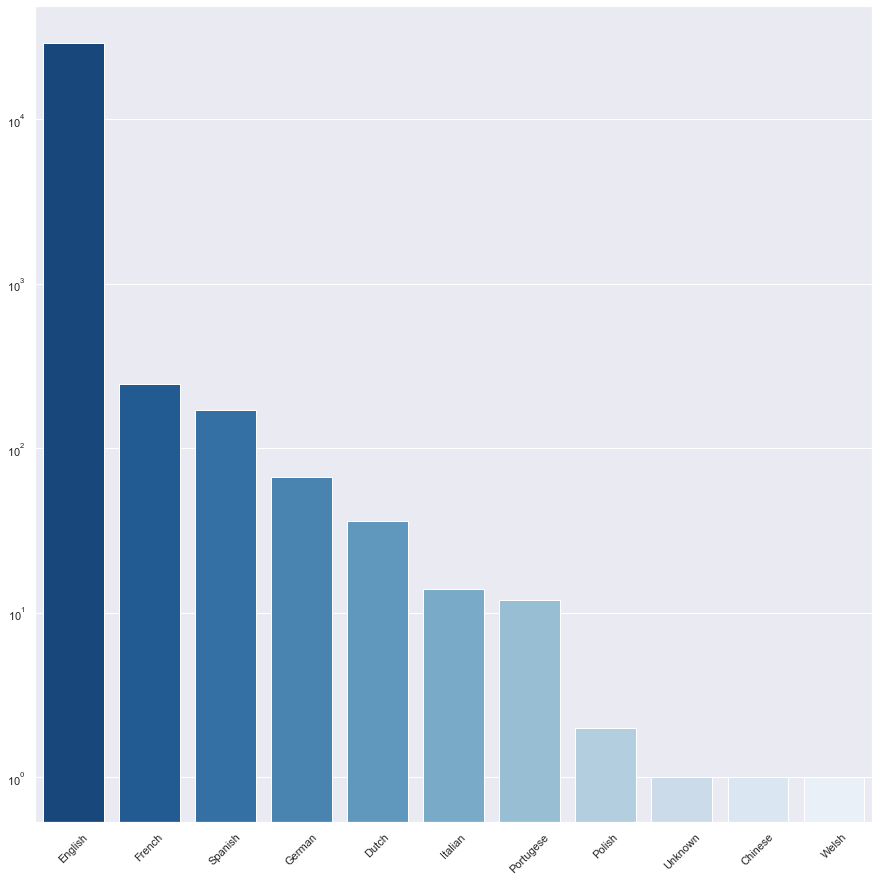

In [22]:
sns.set()
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_yscale('log')
plt.xticks(rotation=45)
sns.barplot(x=lang_distribution.index, y=lang_distribution.values, ax=ax, palette=sns.color_palette('Blues_r', len(lang_distribution)))
plt.show()

In [23]:
covid_df[covid_df['language'] == 'French']

,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count,language
34,82500c03d57e67a212959c13a049dc82c24759cd,10.1016/j.patbio.2008.04.005,Métapneumovirus humain,Résumé Le métapneumovirus humain (hMPV) est un...,Le métapneumovirus humain (hMPV) a été découve...,"Freymuth, F.; Vabret, A.; Legrand, L.; Dina, J...",Pathologie Biologie,349,3666,1353,French
40,acd84940fc5cd8e8f54efd04ab672f5afbd2d7df,10.1016/s0335-7457(96)80118-3,Infections virales et asthme,"Summary Rhinovirus, parainfluenza, influenza, ...","Les infections respiratoires ~t rhinovirus, pa...","Radermecker, M.",Revue Française d'Allergologie et d'Immunologi...,124,2295,1029,French
107,ec96d05a4d7eb88ed151f2f8818802a4a4d8a6cd,10.1016/s0929-693x(07)80019-4,Diarrhées aiguës virales : aspects cliniques e...,Abstract The molecular characterization of gas...,Les nouvelles m6thodes immunologiques et mol6c...,"Olives, J.-P.; Mas, E.",Archives de Pédiatrie,125,1337,643,French
298,422abeb54c5d650351bfd5f471c92cba61b440fa,10.1016/s0929-693x(97)83481-1,Épidémiologie des pneumopathies communautaires...,"Summary Viruses, particularly syncitial respir...",Les infections respiratoires basses sont un mo...,"Marguet, C; Bocquel, N; Mallet, E",Archives de Pédiatrie,81,817,470,French
347,31c3f74777c16704751dde30c4c5a9495890bff6,10.1016/s1773-035x(15)30110-6,Rôle des animaux vertébrés dans l’épidémiologi...,"Résumé Les zoonoses, distinguées ici des malad...",Les zoonoses représentent un groupe particulie...,"Moutou, François",Revue Francophone des Laboratoires,309,3499,1385,French
...,...,...,...,...,...,...,...,...,...,...,...
23443,b08934a33d21cad2d1fbde47f8772448980cb417,10.1007/s13546-011-0314-3,Infections respiratoires virales à herpesvirid...,"Herpesviridae, including herpes simplex virus ...","Résumé Les herpesviridae, essentiellement l'he...","Luyt, C. -E.",Reanimation,190,3411,1035,French
23497,70d49d193252e9892acf1e69f0f8a4305c3458ca,10.1016/s1294-5501(07)73918-3,Infectiologie itinérante,Résumé Objectifs Une prise de conscience s’imp...,Ce titre quelque peu énigmatique est l'occasio...,"Rey, M.",Antibiotiques,291,4052,1594,French
23743,60e14b8a9c26c1cfb37d95fef2c3f95bc6f2f0b7,10.1016/j.medmal.2004.09.005,Les maladies infectieuses émergentes : importa...,Résumé À la fin des années 1970 on a parlé « d...,À la fin des années 1970 on a parlé « de la fi...,"Desenclos, J.-C.; De Valk, H.",Médecine et Maladies Infectieuses,497,8073,2450,French
23848,000eec3f1e93c3792454ac59415c928ce3a6b4ad,10.1016/j.reaurg.2004.02.009,Pneumonie virale sévère de l'immunocompétent,Résumé Les infections virales respiratoires co...,Les pathologies infectieuses respiratoires son...,"Guery, B; d'Escrivan, T; Georges, H; Legout, L...",Réanimation,378,6102,2082,French


## Journal Contributions
Let's see what journal has published the most relevant research on COVID-19 and coronaviruses within this specific dataset!

Since we can only fit so many journals onto one bar plot, we're going to limit the journals we display to those that have contributed more than 100 articles to this dataset.

In [24]:
journal_dist = covid_df['journal'].value_counts()
above_100 = journal_dist[journal_dist.values > 100]
above_100

PLoS One                                               1518
Virology                                                678
Viruses                                                 548
Emerg Infect Dis                                        507
Arch Virol                                              489
Sci Rep                                                 438
Veterinary Microbiology                                 402
Virus Research                                          385
Virol J                                                 355
Journal of Virological Methods                          345
Vaccine                                                 311
PLoS Pathog                                             303
Antiviral Research                                      268
BMC Infect Dis                                          238
Front Immunol                                           211
Journal of Clinical Virology                            210
Front Microbiol                         

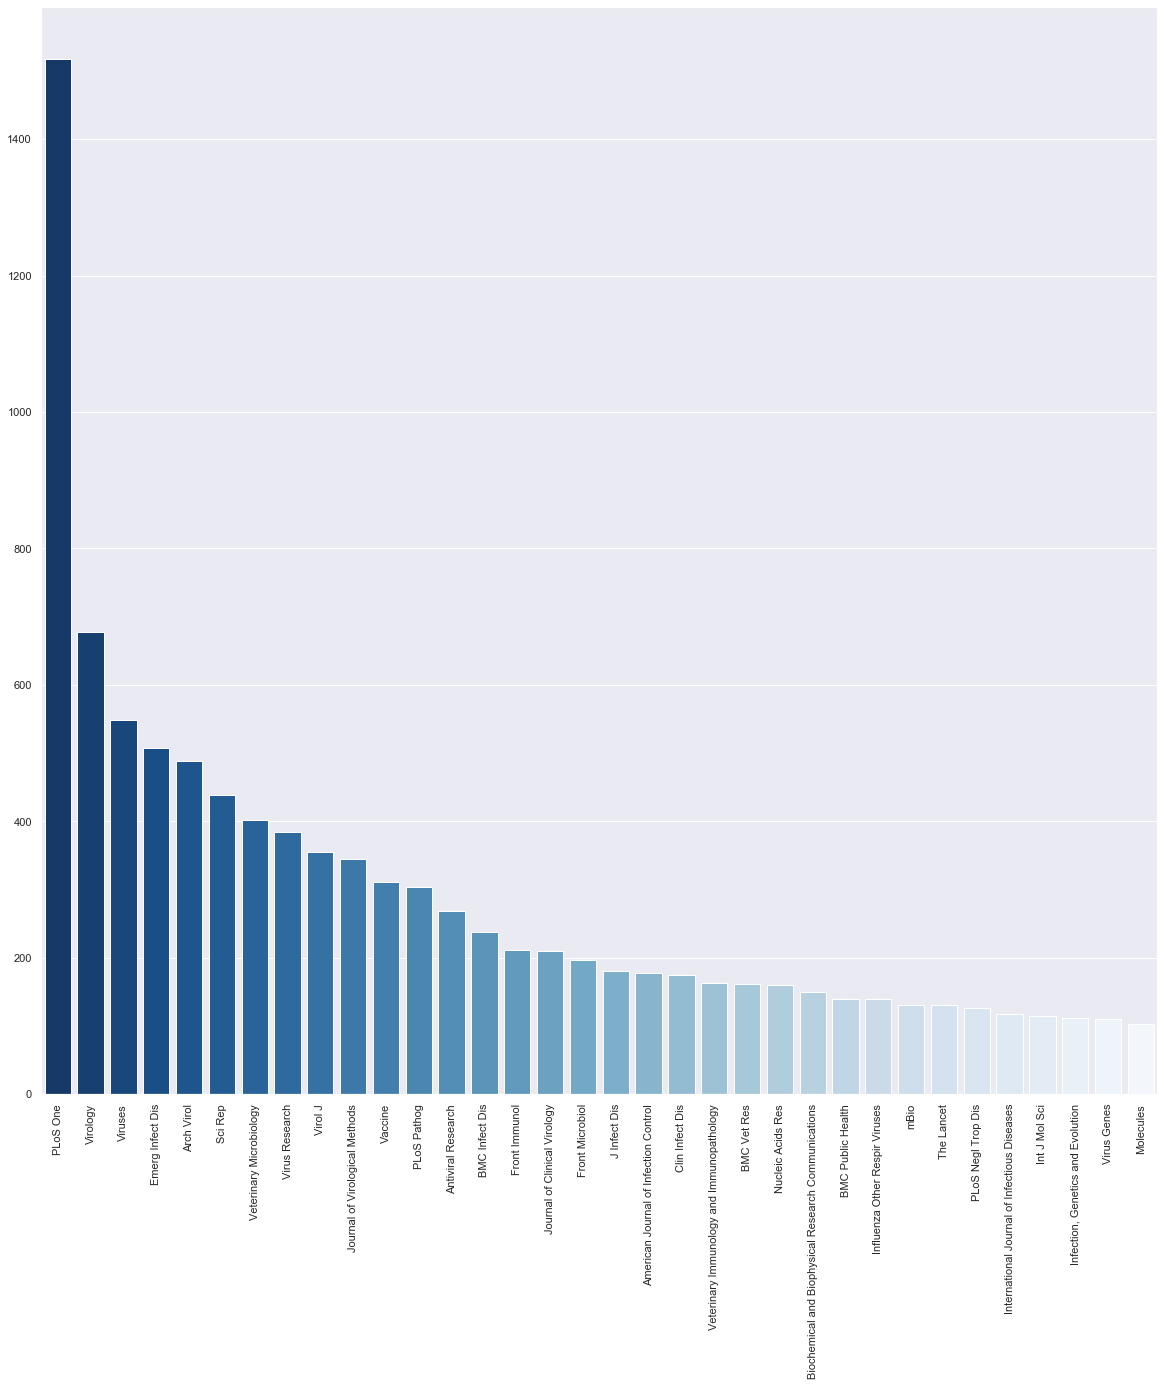

In [25]:
fig, ax_sized = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=90)
sns.barplot(x=above_100.index, y=above_100.values, ax=ax_sized, palette=sns.color_palette('Blues_r', len(above_100)))
plt.show()

## Publication Date
Let's now analyze when our papers have been published, and hopefully see how research has spiked in the past few months or so. We'll first analyze by the years, and then specify for what's happened in the past two years: 

In [26]:
from datetime import datetime

test = pd.merge(covid_df, metadata_df[['sha', 'publish_time']], left_on='paper_id', right_on='sha', how='left')
test['publish_time'] = pd.to_datetime(test['publish_time'], infer_datetime_format=True)
test

,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count,language,sha,publish_time
0,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,10.1080/14787210.2017.1271712,Update on therapeutic options for Middle East ...,Introduction: The Middle East Respiratory Synd...,The Middle East respiratory syndrome coronavir...,"Al-Tawfiq, Jaffar A.; Memish, Ziad A.",Expert Rev Anti Infect Ther,174,2748,996,English,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,2016-12-24
1,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,10.1093/cid/ciaa256,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...","Bryson-Cahn, Chloe; Duchin, Jeffrey; Makarewic...",Clin Infect Dis,50,944,486,English,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,2020-03-12
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,10.1016/b978-0-12-800049-6.00293-6,Evolutionary Medicine IV. Evolution and Emerge...,Abstract This article discusses how evolutiona...,The evolutionary history of humans is characte...,"Scarpino, S.V.",Encyclopedia of Evolutionary Biology,72,2884,1091,English,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,2016-12-31
3,6599ebbef3d868afac9daa4f80fa075675cf03bc,10.1016/j.enpol.2008.08.029,International aviation emissions to 2025: Can ...,Abstract International aviation is growing rap...,"Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew; Wallace, Lailey",Energy Policy,137,5838,1587,English,6599ebbef3d868afac9daa4f80fa075675cf03bc,2009-01-31
4,44290ff75bad8ffaf5d3028420739ce7b08dc2a9,10.1093/jac/dkp502,Inhibition of enterovirus 71 replication and t...,OBJECTIVES: Enterovirus 71 (EV71) causes serio...,Enteroviruses are members of the family Picorn...,"Hung, Hui-Chen; Chen, Tzu-Chun; Fang, Ming-Yu;...",J Antimicrob Chemother,260,3121,1064,English,44290ff75bad8ffaf5d3028420739ce7b08dc2a9,2010-01-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29597,228650bc0429064d800d4b9c5fb0e00c2533a579,10.1371/journal.pone.0215186,Lipidome profiles of postnatal day 2 vaginal s...,We hypothesized that postnatal development of ...,Early nutritional environment affects long ter...,"Harlow, KaLynn; Ferreira, Christina R.; Sobrei...",PLoS One,291,4139,1489,English,228650bc0429064d800d4b9c5fb0e00c2533a579,2019-09-26
29598,2246e28681bde69c65dc9081df367bb661997f19,10.1371/journal.pntd.0000690,"Secondary Syphilis in Cali, Colombia: New Conc...","Venereal syphilis is a multi-stage, sexually t...",Syphilis is a sexually transmitted disease (ST...,"Cruz, Adriana R.; Pillay, Allan; Zuluaga, Ana ...",PLoS Negl Trop Dis,419,5621,1976,English,2246e28681bde69c65dc9081df367bb661997f19,2010-05-18
29599,577c6a13f9ef70e9756890fc66e98f537c01ac0a,10.1038/srep21878,Replication and shedding of MERS-CoV in Jamaic...,The emergence of Middle East respiratory syndr...,Scientific RepoRts | 6:21878 | DOI: 10 .1038/s...,"Munster, Vincent J.; Adney, Danielle R.; van D...",Sci Rep,200,2832,1012,English,577c6a13f9ef70e9756890fc66e98f537c01ac0a,2016-02-22
29600,c5c2bc7a07670d6fb970d84a59aab3832752a3f1,10.3390/v10040199,Role of the ERK1/2 Signaling Pathway in the Re...,We have previously shown that the infection of...,Arenaviruses are enveloped RNA viruses contain...,"Brunetti, Jesús E.; Foscaldi, Sabrina; Quintan...",Viruses,210,4805,1522,English,c5c2bc7a07670d6fb970d84a59aab3832752a3f1,2018-04-17


In [27]:
covid_df = test
covid_df.head() 

,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count,language,sha,publish_time
0,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,10.1080/14787210.2017.1271712,Update on therapeutic options for Middle East ...,Introduction: The Middle East Respiratory Synd...,The Middle East respiratory syndrome coronavir...,"Al-Tawfiq, Jaffar A.; Memish, Ziad A.",Expert Rev Anti Infect Ther,174,2748,996,English,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,2016-12-24
1,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,10.1093/cid/ciaa256,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...","Bryson-Cahn, Chloe; Duchin, Jeffrey; Makarewic...",Clin Infect Dis,50,944,486,English,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,2020-03-12
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,10.1016/b978-0-12-800049-6.00293-6,Evolutionary Medicine IV. Evolution and Emerge...,Abstract This article discusses how evolutiona...,The evolutionary history of humans is characte...,"Scarpino, S.V.",Encyclopedia of Evolutionary Biology,72,2884,1091,English,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,2016-12-31
3,6599ebbef3d868afac9daa4f80fa075675cf03bc,10.1016/j.enpol.2008.08.029,International aviation emissions to 2025: Can ...,Abstract International aviation is growing rap...,"Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew; Wallace, Lailey",Energy Policy,137,5838,1587,English,6599ebbef3d868afac9daa4f80fa075675cf03bc,2009-01-31
4,44290ff75bad8ffaf5d3028420739ce7b08dc2a9,10.1093/jac/dkp502,Inhibition of enterovirus 71 replication and t...,OBJECTIVES: Enterovirus 71 (EV71) causes serio...,Enteroviruses are members of the family Picorn...,"Hung, Hui-Chen; Chen, Tzu-Chun; Fang, Ming-Yu;...",J Antimicrob Chemother,260,3121,1064,English,44290ff75bad8ffaf5d3028420739ce7b08dc2a9,2010-01-20


In [28]:
years_df = covid_df.copy()
years_df['publish_year'] = covid_df['publish_time'].apply(lambda x : x.year)
dates = years_df['publish_year'].value_counts()
dates

2019    2652
2018    2422
2017    2282
2016    2244
2015    2067
2014    1932
2013    1777
2012    1584
2011    1435
2020    1432
2010    1338
2009    1267
2008    1112
2007    1005
2006     920
2005     844
2004     730
2003     318
1991     138
1992     133
1995     125
2002     122
1993     115
2000     114
1988     110
2001     108
1990     107
1998     106
1994     103
1989     101
1996     100
1999      98
1997      96
1987      95
1986      83
1985      53
1984      51
1981      45
1983      44
1982      35
1979      30
1980      30
1978      24
1977      21
1976      15
1975      12
1973       7
1970       7
1974       7
1972       4
1971       2
Name: publish_year, dtype: int64

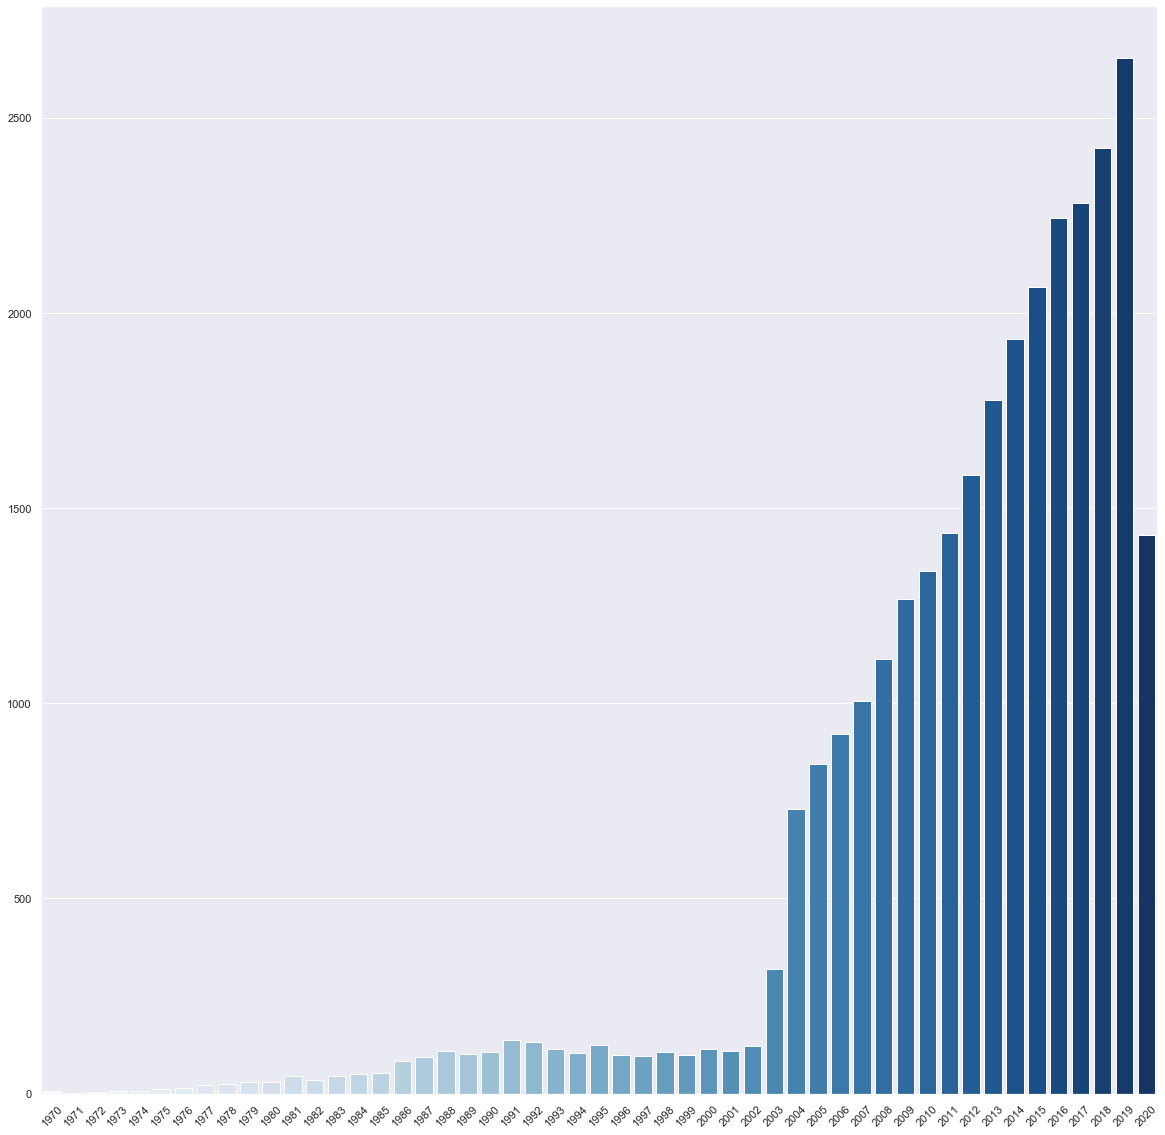

In [29]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=45)
sns.barplot(x=dates.index, y=dates.values, ax=ax, palette=sns.color_palette('Blues', len(dates)))
plt.show()

A super interesting thing to note here is that coronavirus research was relatively low level up until a huge spike in 2004; this __ _directly coincides_ __ with the SARS outbreak from 2002-2003, hence why we can observe a huge spike in research published the following year (!!) This was only further fueled after the outbreak of MERS in 2012, a different species of coronavirus that began to spread in the Middle East.    

Another thing to note is that 2020 is only around halfway through at the time of this writing (May, 2020) - yet, enough research has already been published (and of course, countless other scientsts are likely working on new research as we speak) that it's on pace to likely crush numbers from any prior years. 

Let's now analyze the past two years on research, and see month by month how research has spiked so that we can see how focus has shifted to COVID-19 over the course of time:

In [30]:
# two_years_df = covid_df.copy()
# two_years_df['ym_tuple'] = covid_df['publish_time'].apply(lambda x : (x.year, x.month))
# two_years = months_df['ym_tuple'].value_counts()
# two_years

# NLP + feature extraction
Now that we've successfully cleaned out the data and gotten all the text in a consistent fashion, now we're going to create a bag-of-words model and vectorize each of the documents! This'll then allow us to do some better visualization and run some cool ~ _machine learning_ ~ like PCA and t-SNE to both reduce dimensionality and visualize this better! Our main tool to do this will be NLTK, so if there are any questions concerning documentation, just check out [their documentation](https://www.nltk.org/ "NLTK")

In [31]:
dropped = covid_df[covid_df['language'] == 'en'] # i.e. only select articles written in english, as it'll help parsing/NLP 

In [32]:
covid_df['language'].describe()

count       29602
unique         11
top       English
freq        29049
Name: language, dtype: object

In [33]:
# NLP analysis using Spacy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
import nltk.tokenize as t
import re

stop_words = list(set(stopwords.words('english')))
print(stop_words)


['s', 'am', 'their', 'over', "isn't", 'at', "don't", 'isn', 'yours', 'that', 'an', 'of', 'more', 'through', 'weren', 'during', 'have', 'other', 'on', 'd', "you're", "you'd", 'don', "hadn't", 'before', 'me', "mightn't", 'because', 'those', 'was', 'ourselves', 'them', 'in', 'now', 'do', 'with', 'off', 'most', 'own', 'couldn', 'will', "shan't", 'should', 'his', 'its', 'who', "doesn't", 'such', 'he', 't', 'between', 'from', 'y', "you'll", 'wasn', 'above', "it's", 'not', 'and', 'out', 'when', 'there', 'once', "she's", 'by', 'ain', "wasn't", 'being', 'our', 'all', 'too', 'haven', 'him', 'hasn', 'a', 'ours', 'these', 'the', 'she', 'hers', 'just', "weren't", 'i', 'after', 'what', "couldn't", 'about', 'very', 'didn', 'into', 'against', 'your', "you've", 'if', 'than', "mustn't", 'nor', 'were', 'same', 're', 'both', 'wouldn', "hasn't", 'my', 'doing', 'further', 'can', 'so', 'no', 'how', 'then', 'only', 'aren', 'it', "that'll", 'itself', 'mightn', "aren't", 'where', 'any', 'won', 'shouldn', 'o', '

In [34]:
# add in additional stopwords frequently used in biomedical/research articles
bio_stop_words = ['doi', 'preprint', 'copyright', 'www', 'PMC', 'al.', 'fig', 'fig.', 'permission', 'used', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'biorxiv', 'medrxiv', 'license', 'CZI']

for word in bio_stop_words:
    if word not in stop_words:
        stop_words.append(word)
        
print(stop_words)

['s', 'am', 'their', 'over', "isn't", 'at', "don't", 'isn', 'yours', 'that', 'an', 'of', 'more', 'through', 'weren', 'during', 'have', 'other', 'on', 'd', "you're", "you'd", 'don', "hadn't", 'before', 'me', "mightn't", 'because', 'those', 'was', 'ourselves', 'them', 'in', 'now', 'do', 'with', 'off', 'most', 'own', 'couldn', 'will', "shan't", 'should', 'his', 'its', 'who', "doesn't", 'such', 'he', 't', 'between', 'from', 'y', "you'll", 'wasn', 'above', "it's", 'not', 'and', 'out', 'when', 'there', 'once', "she's", 'by', 'ain', "wasn't", 'being', 'our', 'all', 'too', 'haven', 'him', 'hasn', 'a', 'ours', 'these', 'the', 'she', 'hers', 'just', "weren't", 'i', 'after', 'what', "couldn't", 'about', 'very', 'didn', 'into', 'against', 'your', "you've", 'if', 'than', "mustn't", 'nor', 'were', 'same', 're', 'both', 'wouldn', "hasn't", 'my', 'doing', 'further', 'can', 'so', 'no', 'how', 'then', 'only', 'aren', 'it', "that'll", 'itself', 'mightn', "aren't", 'where', 'any', 'won', 'shouldn', 'o', '

In [35]:
# helper function to remove punctuation from sentences 
def remove_punctuation(sentence):
    sentence = re.sub(r'[^\w\s]','', sentence)
    return sentence

def remove_stopwords(sentence):
    return [word for word in sentence if word not in stop_words]

def parse_text(text): 
    sentences = t.sent_tokenize(text)
    cleaned_sentences = [remove_punctuation(sentence) for sentence in sentences]
    tokenized_sentences = [t.word_tokenize(clean_sentence) for clean_sentence in cleaned_sentences]
    filtered_sentences = [remove_stopwords(t_sentence) for t_sentence in tokenized_sentences]
    tokens = ''
    for sentence in filtered_sentences:
        sentence_str = ' '.join(sentence)
        tokens = tokens + sentence_str + ' '
    return tokens


In [36]:
# checking to see if the function parse_text works correctly

test_article = covid_df.iloc[2020]['body_text']
test_article
output = parse_text(test_article)
print(output)

An emerging pathogen defined causative agent infectious disease whose incidence increasing following appearance new host population whose incidence increasing existing host population result longterm changes underlying epidemiology 1 One potential source emerging pathogen different host species reservoir pathogen already established Table 1 Switches one host species another species jumps led devastating disease epidemics recorded including ongoing HIVAIDS pandemic human communities worldwide decimation European rabbit population myxomatosis mid 20th century catastrophic impact rinderpest African ruminants late 19th century recently widespread mortality North Sea seals result distemper 2 3 4 5 It even argued many main killer diseases humans eg measles TB influenza smallpox emerged pathogens jumping domestic animals humans past 10 000 years 6 Species jumps also given rise devastating epidemics plant pathogens crop species eg potato late blight cultivated potato wild plant species eg near

In [ ]:
tqdm.pandas()
test = covid_df.copy()
test['parsed_text'] = test['body_text'].progress_apply(parse_text)
test

## Word Count Distribution
Another interesting thing to note here is how our journals vary in terms of length! We get a good idea of how long our papers are here, for the most part, our journals are under 5500 words in length, and it's only a very small part of our dataset that has extremely long articles (e.g. the max one with 172000 words in total, sheesh). __Note: this word count data was before we cleaned it using NLTK, so this includes all stopwords as well.__

In [ ]:
sns.set(style='white', palette='muted', color_codes=True)

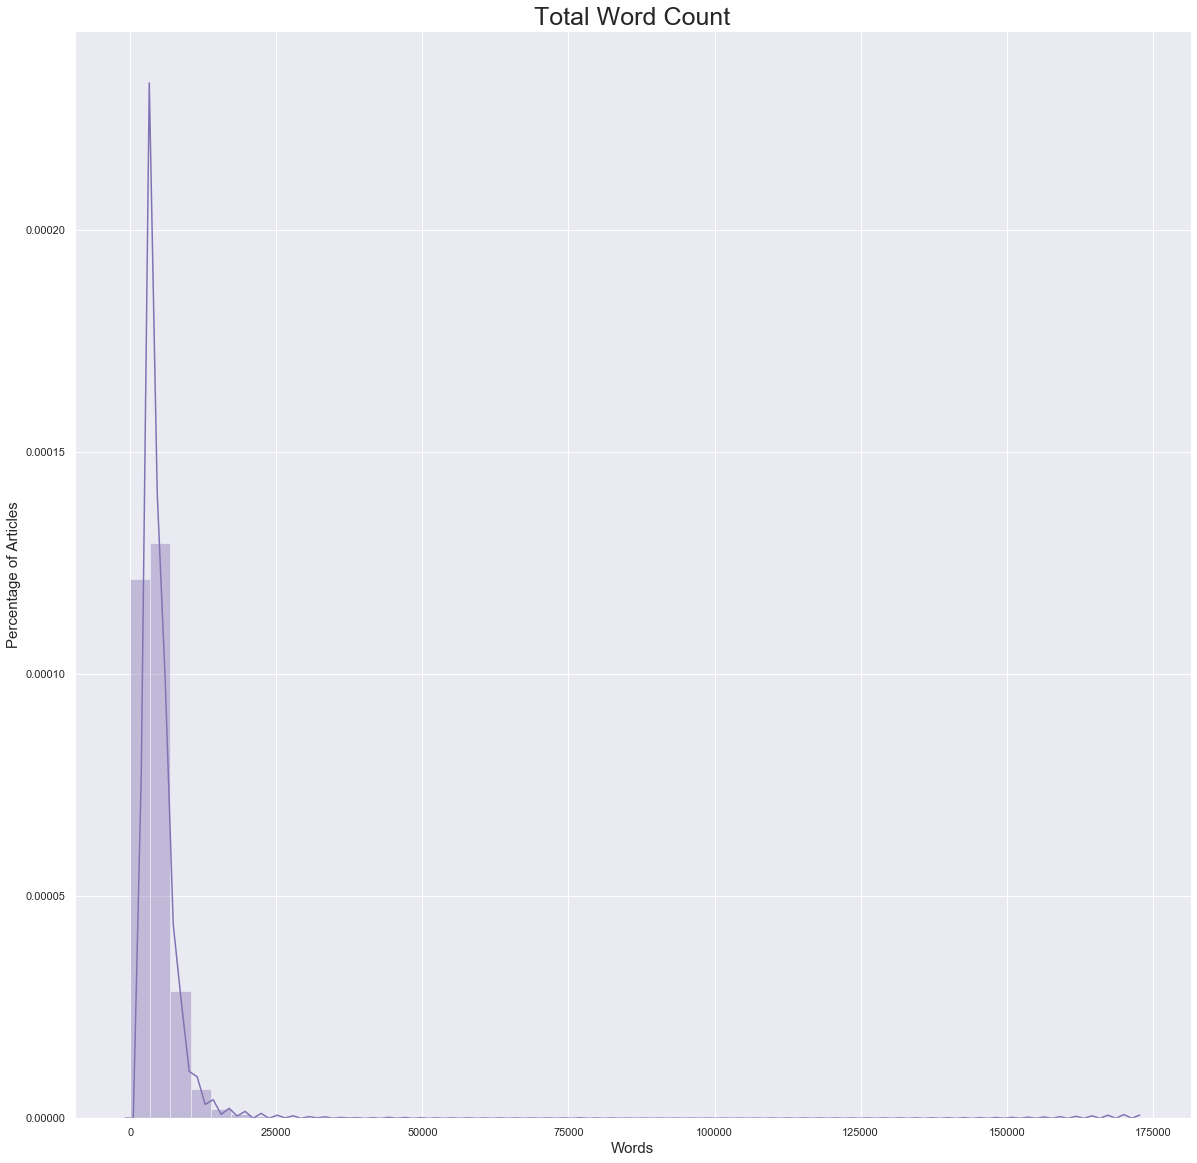

count     29602.000000
mean       4559.986420
std        3528.632565
min           2.000000
25%        2704.250000
50%        3846.000000
75%        5533.000000
max      171948.000000
Name: body_word_count, dtype: float64

In [67]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.ylabel('Percentage of Articles', fontsize=15)
sns.distplot(covid_df['body_word_count'], ax=ax, color='m')
plt.title('Total Word Count', fontsize=25)
plt.xlabel('Words', fontsize=15)
plt.show()
covid_df['body_word_count'].describe()


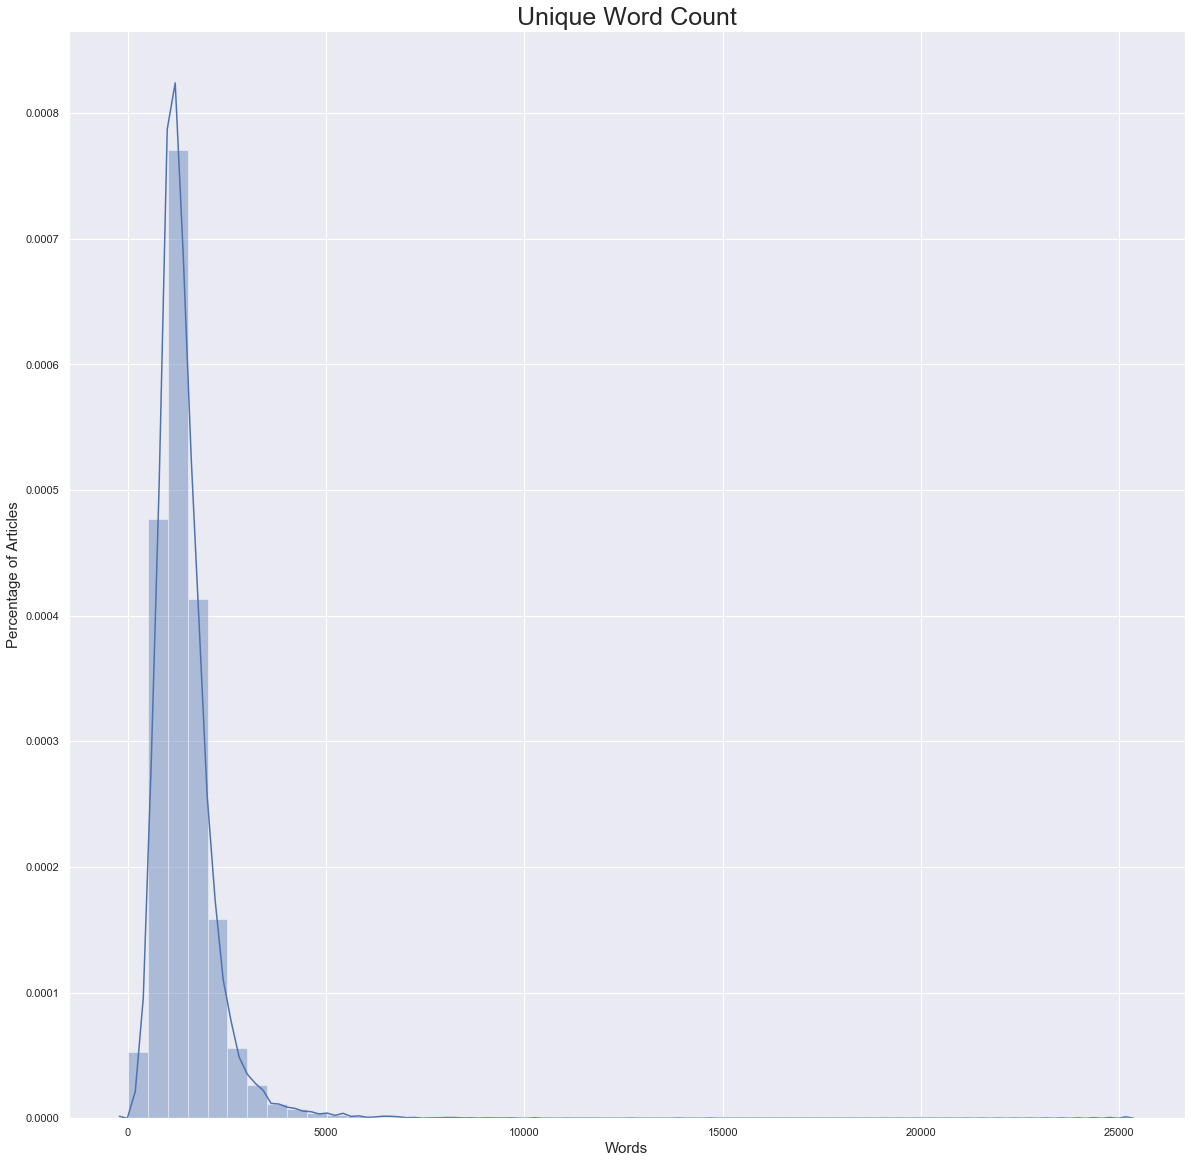

count    29602.000000
mean      1425.128505
std        748.541092
min          2.000000
25%        989.000000
50%       1288.000000
75%       1695.000000
max      25156.000000
Name: body_unique_count, dtype: float64

In [68]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.ylabel('Percentage of Articles', fontsize=15)
sns.distplot(covid_df['body_unique_count'], ax=ax, color='b')
plt.title('Unique Word Count', fontsize=25)
plt.xlabel('Words', fontsize=15)
plt.show()
covid_df['body_unique_count'].describe()

## Vector-Space Modeling Our Documents!
Now comes the NLP part of our project - we'll be utilizing the idea of tf-idf (term frequency - inverse document frequency) in order to make each of our documents into a workable, normalized vector that we can manipulate and compare with other document vectors! We'll be using scikit's inbuilt feature extraction package that has a vectorizer for tf-idf for this task ~ 

> __Note__: I limit the max number of features allowed in the vectorizer to 2<sup>11</sup> because we already found that most of our articles have a word count of less than 5500, and unique body count is even lower (~1700), so we can cover most features for the articles by just limiting it to 2<sup>11</sup> - besides, we want to not take forever to calculate this step either!
> 

Again, if there are any questions on this part, the documentation for the tf-idf vectorizer can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform "scikit documentation")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2**11) # since we know each document has 

# we'll define a function that'll do this work for us so we can apply it to the dataframe
def vectorize_text(text):
    matrix = tfidf.fit_transform(text)
    return matrix

## mAchiNe LEaRnINg !!1!1
Now comes the ~_fancy_~ machine learning algoritms that we've utilized earlier this past sem! For this dataset, we're going to mainly use two unsupervised learning methods (since there's nothing to really classify/regress per se for this dataset of articles) - PCA and K-Means Clustering! 
